In [4]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix,f1_score
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer


d:\MMSERA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def eval(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    # Load checkpoint with save_all_states = False
    # network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    # Load checkpoint with save_all_states = True
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device))["state_dict_backbone"])
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label, am, ve = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        am = am.to(device)
        with torch.no_grad():
            output = network(input_ids,audio, attention_mask = am)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    f1 = f1_score(y_actu, y_pred, average='macro')
    print("Balanced Accuracy: ", wa)
    print("Accuracy: ", ua)
    print("F1: ", f1)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print (cmn)
# Create a figure and axis
    fig, ax = plt.subplots()

# Create a heatmap
    cax = ax.matshow(cmn, cmap='Blues')

# Add color bar
    plt.colorbar(cax)

# Set labels for x and y axes
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Set x and y axis ticks
    plt.xticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])
    plt.yticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])

# Display the values in each cell
    for i in range(4):
        for j in range(4):
            plt.text(j, i, format(cmn[i, j], '.2f'),
                 ha='center', va='center', color='black', fontsize=12)

# Show the plot
    plt.show()

100%|██████████| 679/679 [01:20<00:00,  8.47it/s]


0.5625920471281296
Balanced Accuracy:  0.4309494678171331
Accuracy:  0.5625920471281296
[[ 43  33   1  37]
 [ 33  99   1  60]
 [  6  24   1  50]
 [  5  47   0 239]]
[[37.71929825 28.94736842  0.87719298 32.45614035]
 [17.0984456  51.29533679  0.51813472 31.0880829 ]
 [ 7.40740741 29.62962963  1.2345679  61.72839506]
 [ 1.71821306 16.15120275  0.         82.13058419]]


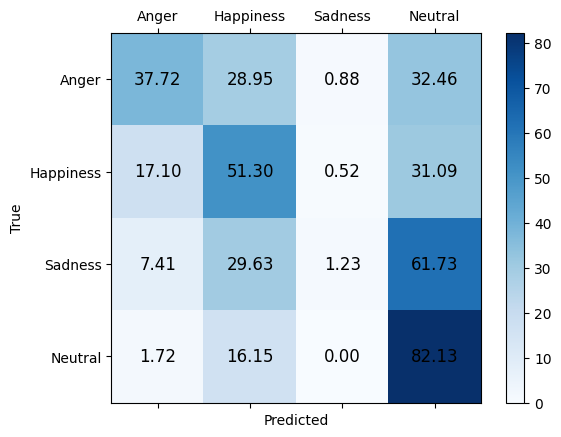

In [9]:
from configs.bert_vggish import Config as roberta_wav2vec2_config

checkpoint_path = "D:\MMSERA/notebooks\checkpoints/bert_vggish_SERVER/20231013-111346" #check point
opt_path = os.path.join(checkpoint_path,"opt.log")
with open(opt_path, "r") as f:
    data = f.read().split("\n")
    # remove all empty strings
    data = list(filter(None, data))
    # convert to dict
    data_dict ={}
    for i in range(len(data)):
        key, value = data[i].split(":")[0].strip(), data[i].split(":")[1].strip()
        if '.' in value and value.replace('.', '').isdigit():
            value = float(value)
        elif value.isdigit():
            value = int(value)
        elif value == 'True':
            value = True
        elif value == 'False':
            value = False
        elif value == 'None':
            value = None
        data_dict[key] = value
# Load checkpoint with save_all_states = False
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt")
# Load checkpoint with save_all_states = False
# ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0.pt")
opt = roberta_wav2vec2_config()
# Replace the default config with the loaded config
for key, value in data_dict.items():
    setattr(opt, key, value)
    
# Set dataset path
opt.data_root="D:\MELD\MELD"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, ckpt_path, tokenizer)

In [ ]:
# checkpoint 20230919-112345 

# after 2 epochs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix
confusion_matrix = np.array([[78.53107345, 6.77966102, 0., 14.68926554],
                             [7.11743772, 72.59786477, 3.91459075, 16.37010676],
                             [2.45098039, 5.39215686, 78.43137255, 13.7254902],
                             [5.53505535, 14.02214022, 11.43911439, 69.00369004]])

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap
cax = ax.matshow(confusion_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set labels for x and y axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Set x and y axis ticks
plt.xticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])
plt.yticks(np.arange(4), ["Anger", "Happiness", "Sadness", "Neutral"])

# Display the values in each cell
for i in range(4):
    for j in range(4):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                 ha='center', va='center', color='black', fontsize=12)

# Show the plot
plt.show()


In [ ]:
# checkpoints /mnt/d/SER_ICIIT_2024/notebooks/checkpoints/bert_vggish_MMSERA/20230919-112345/weights/checkpoint_2_8000.pt

In [ ]:
# Evaluation

In [ ]:
import numpy as np

# Define the confusion matrix
confusion_matrix = np.array([[78.53107345, 6.77966102, 0., 14.68926554],
                             [7.11743772, 72.59786477, 3.91459075, 16.37010676],
                             [2.45098039, 5.39215686, 78.43137255, 13.7254902],
                             [5.53505535, 14.02214022, 11.43911439, 69.00369004]])

import numpy as np

def unweighted_accuracy(confusion_matrix):
    TP = np.diag(confusion_matrix)
    total = confusion_matrix.sum()
    accuracy = sum(TP) / total
    return accuracy

def weighted_accuracy(confusion_matrix):
    TP = np.diag(confusion_matrix)
    class_counts = confusion_matrix.sum(axis=1)
    
    # Calculate accuracy for each class and weight it by the class frequency
    class_accuracies = [TP[i] / class_counts[i] if class_counts[i] > 0 else 0 for i in range(len(TP))]
    
    weighted_accuracy = sum(class_accuracies) / len(class_accuracies)
    return weighted_accuracy

# Example confusion matrix (replace this with your actual confusion matrix)
confusion_matrix = np.array([[78.53107345, 6.77966102, 0., 14.68926554],
                             [7.11743772, 72.59786477, 3.91459075, 16.37010676],
                             [2.45098039, 5.39215686, 78.43137255, 13.7254902],
                             [5.53505535, 14.02214022, 11.43911439, 69.00369004]])

unweighted_acc = unweighted_accuracy(confusion_matrix)
weighted_acc = weighted_accuracy(confusion_matrix)

print("Unweighted Accuracy:", unweighted_acc)
print("Weighted Accuracy:", weighted_acc)



# After 3 epochs

In [ ]:
from configs.bert_vggish import Config as roberta_wav2vec2_config

checkpoint_path = "/mnt/d/SER_ICIIT_2024/notebooks/checkpoints/bert_vggish_MMSERA/20230919-155447" #check point
opt_path = os.path.join(checkpoint_path,"opt.log")
with open(opt_path, "r") as f:
    data = f.read().split("\n")
    # remove all empty strings
    data = list(filter(None, data))
    # convert to dict
    data_dict ={}
    for i in range(len(data)):
        key, value = data[i].split(":")[0].strip(), data[i].split(":")[1].strip()
        if '.' in value and value.replace('.', '').isdigit():
            value = float(value)
        elif value.isdigit():
            value = int(value)
        elif value == 'True':
            value = True
        elif value == 'False':
            value = False
        elif value == 'None':
            value = None
        data_dict[key] = value
# Load checkpoint with save_all_states = False
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt")
# Load checkpoint with save_all_states = False
# ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0.pt")
opt = roberta_wav2vec2_config()
# Replace the default config with the loaded config
for key, value in data_dict.items():
    setattr(opt, key, value)
    
# Set dataset path
opt.data_root="data/IEMOCAP/"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, ckpt_path, tokenizer)

In [ ]:
import numpy as np

def unweighted_accuracy(confusion_matrix):
    TP = np.diag(confusion_matrix)
    total = confusion_matrix.sum()
    accuracy = sum(TP) / total
    return accuracy

def weighted_accuracy(confusion_matrix):
    TP = np.diag(confusion_matrix)
    class_counts = confusion_matrix.sum(axis=1)
    
    # Calculate accuracy for each class and weight it by the class frequency
    class_accuracies = [TP[i] / class_counts[i] if class_counts[i] > 0 else 0 for i in range(len(TP))]
    
    weighted_accuracy = sum(class_accuracies) / len(class_accuracies)
    return weighted_accuracy

# Example confusion matrix (replace this with your actual confusion matrix)
confusion_matrix = np.array([[76.83615819,  8.47457627,  5.64971751,  9.03954802],
 [3.55871886, 76.15658363,  7.82918149, 12.45551601],
 [1.96078431,  2.94117647, 91.17647059,  3.92156863],
 [6.64206642, 15.49815498, 22.87822878, 54.98154982]])

unweighted_acc = unweighted_accuracy(confusion_matrix)
weighted_acc = weighted_accuracy(confusion_matrix)

print("Unweighted Accuracy:", unweighted_acc)
print("Weighted Accuracy:", weighted_acc)
